## Sub Question
### Machine learning model comparision and prediction income level between Native-Born US and immigrant population sub-group in the census dataset.

### README:
### 1. PLEASE place this notebook in the Colab root folder with the dataset file'Training_set_census.csv' or any environment with plotly packages installed, it requires plotly to preview the graphs/charts, also pip install geopandas library in the begining of this notebook (click the Runtime -> Run all once all the files ready)

### 2. PLEASE unzip the geo_data.zip file (14 files inside the zip), and place the geo_data folder with all the upload contents inside in the folder into the '/content/drive/My Drive/Colab Notebooks/' path (this is the defalt google drive path). Example: shapefile_path = '/content/drive/My Drive/Colab Notebooks/geo_data/usa-states-census-2014.shp'

### 3.Column to define immigrant and non-immigrant - citizenship: row 'Native- Born in the United States' define as Non-immigrant, the other are defined immigrants

### 4. Credit: Banghui completed most of the feature engineering part, I did an exetra transformation for numerical 'age' column to categorical 'age_cat' columns in the feature engineering step

### 5. Models applied in this sub_question: Random Forest, XGBoost, Logistic Regression, LightGBM

### 6. PLEASE see WORD document for the summary of this sub question

### Codes start Here

In [ ]:
# install the geopandas for the first run
!pip install geopandas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import drive
DRIVE = '/content/drive/'
PATH = 'My Drive/Colab Notebooks/'
SOURCE_DATA = 'Training_set_census.csv'

drive.mount(DRIVE)
census_df = pd.read_csv(DRIVE + PATH + SOURCE_DATA)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
census_df.shape

(200000, 41)

In [ ]:
census_df.columns

Index(['age', 'class_of_worker', 'industry_code', 'occupation_code',
       'education', 'wage_per_hour', 'enrolled_in_edu_inst_lastwk',
       'marital_status', 'major_industry_code', 'major_occupation_code',
       'race', 'hispanic_origin', 'sex', 'member_of_labor_union',
       'reason_for_unemployment', 'full_parttime_employment_stat',
       'capital_gains', 'capital_losses', 'dividend_from_Stocks',
       'tax_filer_status', 'region_of_previous_residence',
       'state_of_previous_residence', 'd_household_family_stat',
       'd_household_summary', 'migration_msa', 'migration_reg',
       'migration_within_reg', 'live_1_year_ago', 'migration_sunbelt',
       'num_person_Worked_employer', 'family_members_under_18',
       'country_father', 'country_mother', 'country_self', 'citizenship',
       'business_or_self_employed', 'fill_questionnaire_veteran_admin',
       'veterans_benefits', 'weeks_worked_in_year', 'year', 'income_level'],
      dtype='object')

In [ ]:
census_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 41 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   age                               200000 non-null  int64 
 1   class_of_worker                   200000 non-null  object
 2   industry_code                     200000 non-null  int64 
 3   occupation_code                   200000 non-null  int64 
 4   education                         200000 non-null  object
 5   wage_per_hour                     200000 non-null  int64 
 6   enrolled_in_edu_inst_lastwk       200000 non-null  object
 7   marital_status                    200000 non-null  object
 8   major_industry_code               200000 non-null  object
 9   major_occupation_code             200000 non-null  object
 10  race                              200000 non-null  object
 11  hispanic_origin                   199408 non-null  object
 12  se

### Data Cleaning - Removing spacing and combined redundant column name values

In [ ]:
#confirm the spaces are removed and all the same columns are combined
for i in census_df.columns:
    if census_df[i].dtype != 'int64':
        census_df[i] = census_df[i].str.strip()
        print ("---- %s ---" % i)
        print(census_df[i].unique())

---- class_of_worker ---
['Private' 'Not in universe' 'Self-employed-not incorporated'
 'Local government' 'Self-employed-incorporated' 'Federal government'
 'State government' 'Never worked' 'Without pay']
---- education ---
['Some college but no degree' 'Bachelors degree(BA AB BS)'
 'Masters degree(MA MS MEng MEd MSW MBA)' 'High school graduate'
 'Children' '9th grade' '1st 2nd 3rd or 4th grade'
 'Associates degree-occup /vocational' '10th grade'
 'Associates degree-academic program' '7th and 8th grade' '11th grade'
 '5th or 6th grade' 'Doctorate degree(PhD EdD)' 'Less than 1st grade'
 '12th grade no diploma' 'Prof school degree (MD DDS DVM LLB JD)']
---- enrolled_in_edu_inst_lastwk ---
['College or university' 'Not in universe' 'High school']
---- marital_status ---
['Never married' 'Married-civilian spouse present' 'Divorced'
 'Married-spouse absent' 'Widowed' 'Married-A F spouse present'
 'Separated']
---- major_industry_code ---
['Education' 'Finance insurance and real estate'
 '

In [ ]:
census_df.marital_status.value_counts()

Never married                      85582
Married-civilian spouse present    85440
Divorced                           12908
Widowed                            10448
Separated                           3464
Married-spouse absent               1493
Married-A F spouse present           665
Name: marital_status, dtype: int64

:### Apply worldmap template to run data statistic visualzation for immigrant

In [ ]:
import geopandas as gpd

In [ ]:
shapefile_path = DRIVE + PATH + 'geo_data/ne_110m_admin_0_countries.shp'
worldmap = gpd.read_file(shapefile_path)
worldmap_selected = worldmap[['ADMIN', 'LABEL_X', 'LABEL_Y', 'geometry']]

In [ ]:
census_df_sq_immigrant = census_df[census_df['citizenship'] != 'Native- Born in the United States']

In [ ]:
feature = 'country_self'
census_df_sq_feature = census_df_sq_immigrant[feature].value_counts()
census_df_sq_feature = census_df_sq_feature.drop('?')

census_df_sq_feature_resetindex = census_df_sq_feature.reset_index()
census_df_sq_feature_resetindex.columns=['ADMIN', 'count_num']
census_df_sq_feature_resetindex

census_df_sq_feature_resetindex['ADMIN'] = census_df_sq_feature_resetindex['ADMIN'].replace('-', ' ', regex=True)

# Left Join census_df_sq
merged_df = pd.merge(worldmap_selected, census_df_sq_feature_resetindex, on='ADMIN', how='left')

#Fill NaNs for missing countries/areas
#England
merged_df.loc[11, 'LABEL_X'] = -1.1743
merged_df.loc[11, 'LABEL_Y'] = 52.3555

#Colombia
merged_df.loc[13, 'LABEL_X'] = -74.2973
merged_df.loc[13, 'LABEL_Y'] = 4.5709

#Guam
merged_df.loc[31, 'LABEL_X'] = 144.793732
merged_df.loc[31, 'LABEL_Y'] = 13.444304

#Hong Kong
merged_df.loc[32, 'LABEL_X'] = 114.177216
merged_df.loc[32, 'LABEL_Y'] = 22.302711

#Trinadad and Tobago
merged_df.loc[36, 'LABEL_X'] = -60.918400
merged_df.loc[36, 'LABEL_Y'] = 10.998900

#Yugoslavia
merged_df.loc[37, 'LABEL_X'] = 18.25
merged_df.loc[37, 'LABEL_Y'] = 43.85

#Scotland
merged_df.loc[38, 'LABEL_X'] = -4.2026
merged_df.loc[38, 'LABEL_Y'] = 56.4907

#Holand Netherlands
merged_df.loc[41, 'LABEL_X'] = 5.2913
merged_df.loc[41, 'LABEL_Y'] = 52.1326

Text(155.59722222222223, 0.5, 'Latitude')

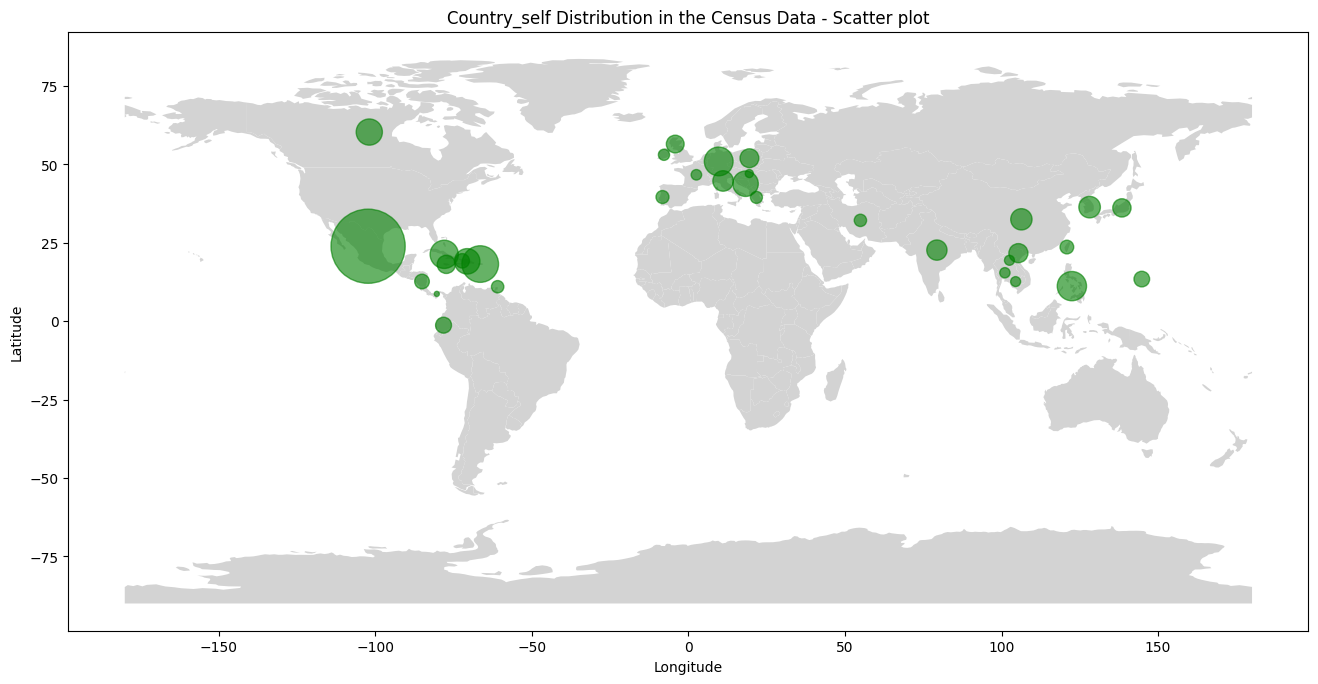

In [ ]:
# Scatter Plot
fig, ax = plt.subplots(figsize=(16, 9))
worldmap.plot(color="lightgrey", ax=ax)
x = merged_df['LABEL_X']
y = merged_df['LABEL_Y']

plt.scatter(x, y, alpha=0.6, s=merged_df['count_num']/2,
            color = 'green')

plt.title(f"{feature.capitalize()} Distribution in the Census Data - Scatter plot")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

#### Figure 1: World map scatter plot distribution of immirant population

Text(155.59722222222223, 0.5, 'Latitude')

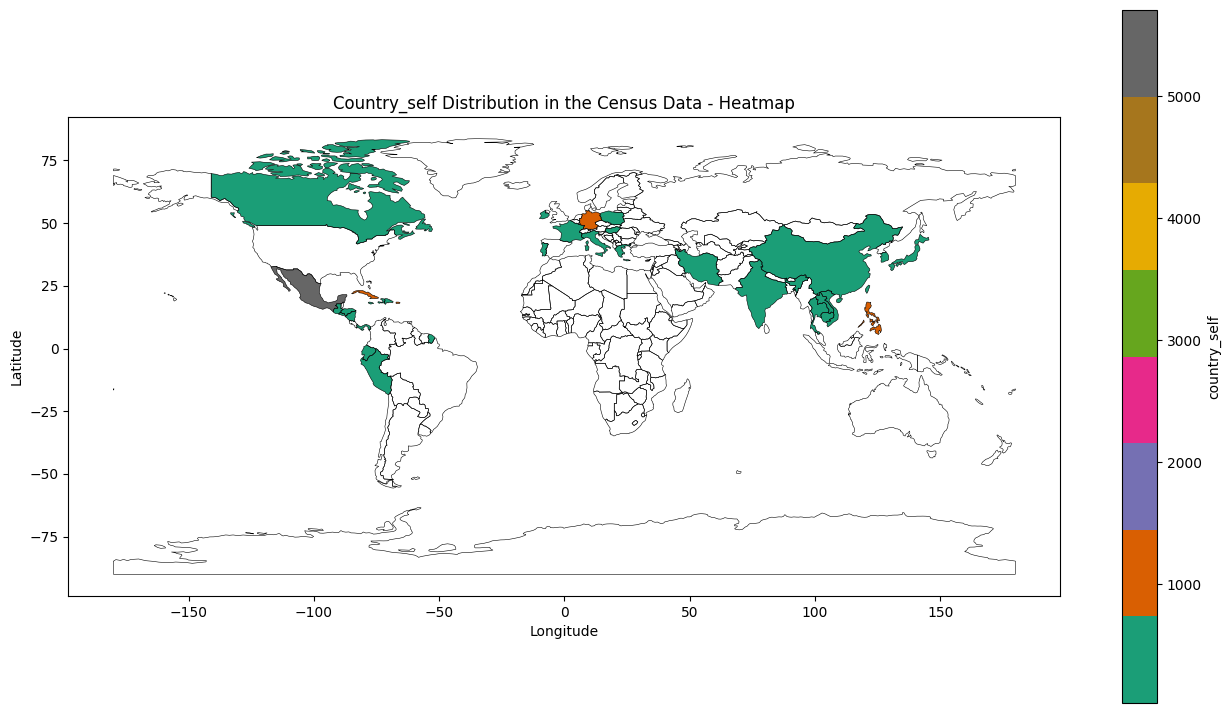

In [ ]:
# Heatmap plot
fig = plt.figure(1, figsize=(16,9))
ax = fig.add_subplot()

# states_merged_df.apply(lambda x: ax.annotate(text=x.STUSPS, xy=x.geometry.centroid.coords[0], ha='center', fontsize=9),axis=1);
merged_df.boundary.plot(ax=ax, color='Black', linewidth=0.4)

merged_df.plot(ax=ax, column=merged_df.count_num, cmap='Dark2', figsize=(16, 9), legend=True, legend_kwds={'label':'country_self'})
plt.title(f"{feature.capitalize()} Distribution in the Census Data - Heatmap")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

#### Figure 2: World map heatmap plot distribution of immirant population

In [ ]:
from urllib.request import UnknownHandler
# census_df.citizenship.value_counts()
values_to_replace = ['?', 'nan']
census_df_country_self_wc = census_df.country_self[census_df.country_self!='United-States'].replace(values_to_replace, 'Unknown').astype('str')
census_df_country_self_wc = census_df_country_self_wc.fillna('Unknown')
# census_df_country_self_wc.value_counts()

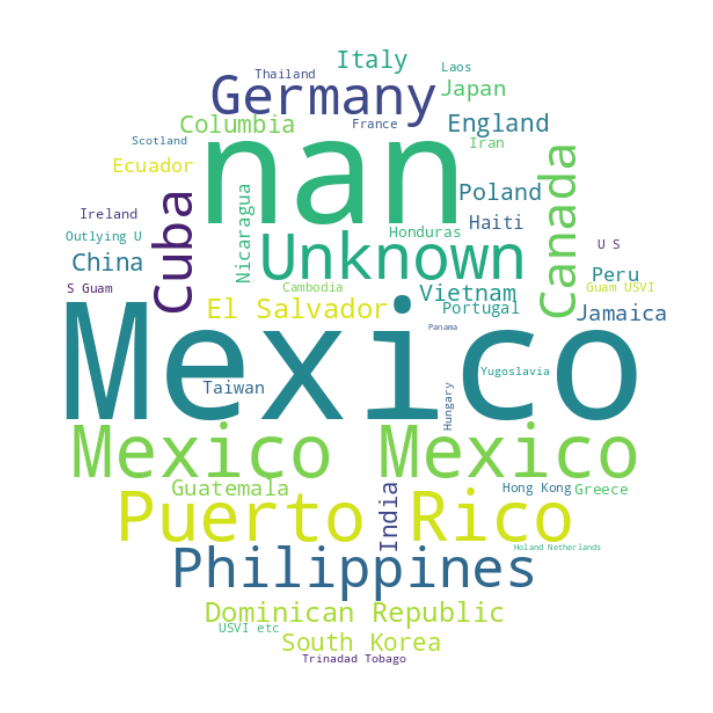

In [ ]:
from wordcloud import WordCloud
from PIL import Image

shape_mask = np.array(Image.open(DRIVE + PATH + "Black_Spot.png"))
# wordcloud in 'immigrant'
plt.subplots(figsize = (16, 9))
wordcloud=WordCloud(background_color = 'white',
                    width = 1600,
                    height = 900,
                    colormap='viridis',
                    mask=shape_mask
                    ).generate(" ".join(census_df_country_self_wc))

plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

### Figure 3: Word cloud plot of immigrant original country ('country_self')

##Feature Engineering


### Transform "industry_code", "occupation_code"

In [ ]:
census_df.industry_code = census_df.industry_code.astype('object')
census_df.occupation_code = census_df.occupation_code.astype('object')

census_df.major_industry_code.value_counts()

Not in universe or children            99570
Retail trade                           17069
Manufacturing-durable goods             9221
Education                               8478
Manufacturing-nondurable goods          6995
Finance insurance and real estate       6370
Construction                            6091
Business and repair services            5806
Medical except hospital                 4792
Public administration                   4717
Other professional services             4657
Transportation                          4294
Hospital services                       3973
Wholesale trade                         3707
Agriculture                             2985
Personal services except private HH     2905
Social services                         2477
Entertainment                           1644
Communications                          1227
Utilities and sanitary services         1203
Private household services               964
Mining                                   614
Forestry a

#### following 4 columns: 'major_industry_code','industry_code', 'occupation_code', 'major_occupation_code' have a lot of repetitive information, Just use one is enough. Let's keep "major_industry_code"

In [ ]:
census_df.drop(columns=['industry_code', 'occupation_code', 'major_occupation_code'],  inplace=True)
census_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 38 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   age                               200000 non-null  int64 
 1   class_of_worker                   200000 non-null  object
 2   education                         200000 non-null  object
 3   wage_per_hour                     200000 non-null  int64 
 4   enrolled_in_edu_inst_lastwk       200000 non-null  object
 5   marital_status                    200000 non-null  object
 6   major_industry_code               200000 non-null  object
 7   race                              200000 non-null  object
 8   hispanic_origin                   199408 non-null  object
 9   sex                               200000 non-null  object
 10  member_of_labor_union             200000 non-null  object
 11  reason_for_unemployment           200000 non-null  object
 12  fu

#### 'race', 'hispanic_origin'

In [ ]:
print('race value_counts:\n', census_df.race.value_counts())
print('\nhispanic_origin value_counts:\n', census_df.hispanic_origin.value_counts())
dist_hispanic_origin = census_df[['hispanic_origin', 'income_level']].groupby(['hispanic_origin']).agg({'income_level':[np.mean,np.std]})
print('\ndistribution of hispanic origin:\n', dist_hispanic_origin)

race value_counts:
 White                          167912
Black                           20216
Asian or Pacific Islander        5888
Other                            3704
Amer Indian Aleut or Eskimo      2280
Name: race, dtype: int64

hispanic_origin value_counts:
 All other                    172545
Mexican-American               8057
Mexican (Mexicano)             7157
Central or South American      3916
Puerto Rican                   3220
Other Spanish                  2511
Cuban                          1140
Chicano                         304
Do not know                     295
NA                              263
Name: hispanic_origin, dtype: int64

distribution of hispanic origin:
                           income_level          
                                  mean       std
hispanic_origin                                 
All other                     0.081840  0.274121
Central or South American     0.024515  0.154661
Chicano                       0.032895  0.178655
Cuban   

In [ ]:
census_df['is_hispanic'] = 1
census_df.loc[census_df.hispanic_origin == 'All other', 'is_hispanic'] = 0
print("distribution of hispanic:\n", census_df[['is_hispanic', 'income_level']].groupby(['is_hispanic']).agg({'income_level':[np.mean,np.std]}))

distribution of hispanic:
             income_level          
                    mean       std
is_hispanic                       
0               0.081840  0.274121
1               0.027354  0.163115


### Drop hispanic_origin

In [ ]:
census_df.drop(columns=['hispanic_origin'], inplace=True)
census_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 38 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   age                               200000 non-null  int64 
 1   class_of_worker                   200000 non-null  object
 2   education                         200000 non-null  object
 3   wage_per_hour                     200000 non-null  int64 
 4   enrolled_in_edu_inst_lastwk       200000 non-null  object
 5   marital_status                    200000 non-null  object
 6   major_industry_code               200000 non-null  object
 7   race                              200000 non-null  object
 8   sex                               200000 non-null  object
 9   member_of_labor_union             200000 non-null  object
 10  reason_for_unemployment           200000 non-null  object
 11  full_parttime_employment_stat     200000 non-null  object
 12  ca

### 'marital_status'

In [ ]:
dist_marital_status = census_df[['marital_status', 'income_level']].groupby(['marital_status']).agg({'income_level':[np.mean,np.std]})
print('distribution of marital_status:\n', dist_marital_status)

distribution of marital_status:
                                 income_level          
                                        mean       std
marital_status                                        
Divorced                            0.098544  0.298060
Married-A F spouse present          0.025564  0.157949
Married-civilian spouse present     0.135159  0.341896
Married-spouse absent               0.072338  0.259133
Never married                       0.015587  0.123873
Separated                           0.053695  0.225448
Widowed                             0.038955  0.193497


### Investment: 'capital_gains', 'capital_losses', 'dividend_from_Stocks'
### We don't want use income to do trivial prediction on income. But they are highly positive related to income level. So the idea here is to aggregate the three features into one binary feature, "has_investment".

In [ ]:
print("Gain:", census_df.income_level.loc[census_df.capital_gains > 0].mean())
print("Loss:", census_df.income_level.loc[census_df.capital_losses > 0].mean())
print("Dividend:", census_df.income_level.loc[census_df.dividend_from_Stocks > 0].mean())

print("\nGain:\n", census_df[['capital_gains', 'income_level']].groupby(['capital_gains']).agg({'income_level':[np.mean,np.std]}))
print("\nLoss:\n", census_df[['capital_losses', 'income_level']].groupby(['capital_losses']).agg({'income_level':[np.mean,np.std]}))
print("\nDividend:\n", census_df[['dividend_from_Stocks', 'income_level']].groupby(['dividend_from_Stocks']).agg({'income_level':[np.mean,np.std]}))

print("\nRich:\n", census_df.income_level.loc[census_df.dividend_from_Stocks == 99999])

Gain: 0.36755857124567914
Loss: 0.34362745098039216
Dividend: 0.2896613995485327

Gain:
               income_level          
                      mean       std
capital_gains                       
0                 0.062444  0.241960
114               0.000000  0.000000
401               0.000000  0.000000
594               0.000000  0.000000
914               0.000000  0.000000
...                    ...       ...
25236             1.000000  0.000000
27828             1.000000  0.000000
34095             0.000000  0.000000
41310             0.000000  0.000000
99999             0.888651  0.314901

[130 rows x 2 columns]

Loss:
                income_level          
                       mean       std
capital_losses                       
0                  0.068753  0.253034
155                0.000000       NaN
213                0.000000  0.000000
323                0.545455  0.522233
419                0.000000  0.000000
...                     ...       ...
3683               

### Create a new feature 'has_investment'

In [ ]:
census_df['has_investment'] = 0
census_df.loc[census_df.capital_gains > 0, 'has_investment'] = 1
census_df.loc[census_df.capital_losses > 0, 'has_investment'] = 1
census_df.loc[census_df.dividend_from_Stocks > 0, 'has_investment'] = 1
print("Has Investment:", census_df[['has_investment', 'income_level']].groupby(['has_investment']).agg({'income_level':[np.mean,np.std]}))

Has Investment:                income_level          
                       mean       std
has_investment                       
0                  0.036318  0.187081
1                  0.284456  0.451162


### Drop 'capital_gains', 'capital_losses', 'dividend_from_Stocks'

In [ ]:
census_df.drop(columns=['capital_gains', 'capital_losses', 'dividend_from_Stocks'], inplace=True)
census_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 36 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   age                               200000 non-null  int64 
 1   class_of_worker                   200000 non-null  object
 2   education                         200000 non-null  object
 3   wage_per_hour                     200000 non-null  int64 
 4   enrolled_in_edu_inst_lastwk       200000 non-null  object
 5   marital_status                    200000 non-null  object
 6   major_industry_code               200000 non-null  object
 7   race                              200000 non-null  object
 8   sex                               200000 non-null  object
 9   member_of_labor_union             200000 non-null  object
 10  reason_for_unemployment           200000 non-null  object
 11  full_parttime_employment_stat     200000 non-null  object
 12  ta

### Transform "class_of_worker"

In [ ]:
census_df.class_of_worker.value_counts()

Not in universe                   99144
Private                           72923
Self-employed-not incorporated     8694
Local government                   7878
State government                   4360
Self-employed-incorporated         3492
Federal government                 2942
Never worked                        426
Without pay                         141
Name: class_of_worker, dtype: int64

In [ ]:
dist_class_of_worker = census_df[['class_of_worker', 'income_level']].groupby(['class_of_worker']).agg({'income_level':[np.mean,np.std]})
print('distribution of class_of_worker:\n', dist_class_of_worker)

distribution of class_of_worker:
                                income_level          
                                       mean       std
class_of_worker                                      
Federal government                 0.236574  0.425051
Local government                   0.129855  0.336165
Never worked                       0.004695  0.068438
Not in universe                    0.010671  0.102750
Private                            0.121018  0.326150
Self-employed-incorporated         0.393184  0.488527
Self-employed-not incorporated     0.148263  0.355381
State government                   0.138761  0.345737
Without pay                        0.007092  0.084215


In [ ]:
census_df.loc[census_df.class_of_worker == 'Not in universe', 'class_of_worker'] = 'not_paid_worker'
census_df.loc[census_df.class_of_worker == 'Never worked', 'class_of_worker'] = 'not_paid_worker'
census_df.loc[census_df.class_of_worker == 'Without pay', 'class_of_worker'] = 'not_paid_worker'

In [ ]:
dist_class_of_worker = census_df[['class_of_worker', 'income_level']].groupby(['class_of_worker']).agg({'income_level':[np.mean,np.std]})
print('class_of_worker value_counts after feature engineering:\n', census_df.class_of_worker.value_counts())
print('\ndistribution of class_of_worker after feature engineering:\n', dist_class_of_worker)

class_of_worker value_counts after feature engineering:
 not_paid_worker                   99711
Private                           72923
Self-employed-not incorporated     8694
Local government                   7878
State government                   4360
Self-employed-incorporated         3492
Federal government                 2942
Name: class_of_worker, dtype: int64

distribution of class_of_worker after feature engineering:
                                income_level          
                                       mean       std
class_of_worker                                      
Federal government                 0.236574  0.425051
Local government                   0.129855  0.336165
Private                            0.121018  0.326150
Self-employed-incorporated         0.393184  0.488527
Self-employed-not incorporated     0.148263  0.355381
State government                   0.138761  0.345737
not_paid_worker                    0.010641  0.102604


### Transform "education"

In [ ]:
census_df.education.value_counts()

High school graduate                      48114
Children                                  46693
Some college but no degree                28046
Bachelors degree(BA AB BS)                20467
7th and 8th grade                          7986
10th grade                                 7440
Masters degree(MA MS MEng MEd MSW MBA)     7003
11th grade                                 6923
9th grade                                  6151
Associates degree-occup /vocational        5441
Associates degree-academic program         4379
5th or 6th grade                           3259
12th grade no diploma                      2146
Prof school degree (MD DDS DVM LLB JD)     1959
1st 2nd 3rd or 4th grade                   1785
Doctorate degree(PhD EdD)                  1385
Less than 1st grade                         823
Name: education, dtype: int64

#### Transform education year to numerical values

In [ ]:
census_df['education_years'] = 0
census_df.loc[census_df.education == 'High school graduate', 'education_years'] = 12
census_df.loc[census_df.education == 'Children', 'education_years'] = 0
census_df.loc[census_df.education == 'Some college but no degree', 'education_years'] = 13
census_df.loc[census_df.education == 'Bachelors degree(BA AB BS)', 'education_years'] = 16
census_df.loc[census_df.education == '7th and 8th grade', 'education_years'] = 7.5
census_df.loc[census_df.education == '10th grade', 'education_years'] = 10
census_df.loc[census_df.education == '11th grade', 'education_years'] = 11
census_df.loc[census_df.education == '9th grade', 'education_years'] = 9
census_df.loc[census_df.education == 'Associates degree-occup /vocational', 'education_years'] = 14
census_df.loc[census_df.education == 'Associates degree-academic program', 'education_years'] = 15
census_df.loc[census_df.education == '5th or 6th grade', 'education_years'] = 5.5
census_df.loc[census_df.education == '12th grade no diploma', 'education_years'] = 11.5
census_df.loc[census_df.education == 'Masters degree(MA MS MEng MEd MSW MBA)', 'education_years'] = 18
census_df.loc[census_df.education == 'Prof school degree (MD DDS DVM LLB JD)', 'education_years'] = 19
census_df.loc[census_df.education == 'Doctorate degree(PhD EdD)', 'education_years'] = 21
census_df.loc[census_df.education == 'Less than 1st grade', 'education_years'] = 0.5

print('education_years describe:\n', census_df['education_years'].describe())

print('\neducation_years value counts sorted:\n', census_df['education_years'].value_counts().sort_index())

education_years describe:
 count    200000.000000
mean          9.562395
std           5.987608
min           0.000000
25%           5.500000
50%          12.000000
75%          13.000000
max          21.000000
Name: education_years, dtype: float64

education_years value counts sorted:
 0.0     48478
0.5       823
5.5      3259
7.5      7986
9.0      6151
10.0     7440
11.0     6923
11.5     2146
12.0    48114
13.0    28046
14.0     5441
15.0     4379
16.0    20467
18.0     7003
19.0     1959
21.0     1385
Name: education_years, dtype: int64


In [ ]:
dist_education = census_df[['education', 'income_level']].groupby(['education']).agg({'income_level':[np.mean,np.std]})
print('distribution of education:\n', dist_education)

distribution of education:
                                        income_level          
                                               mean       std
education                                                    
10th grade                                 0.010753  0.103143
11th grade                                 0.013433  0.115130
12th grade no diploma                      0.016775  0.128459
1st 2nd 3rd or 4th grade                   0.009524  0.097151
5th or 6th grade                           0.009205  0.095516
7th and 8th grade                          0.009517  0.097094
9th grade                                  0.007316  0.085226
Associates degree-academic program         0.107787  0.310147
Associates degree-occup /vocational        0.090057  0.286290
Bachelors degree(BA AB BS)                 0.231006  0.421487
Children                                   0.000000  0.000000
Doctorate degree(PhD EdD)                  0.563899  0.496079
High school graduate                      

In [ ]:
census_df['college_graduate'] = 0
census_df.loc[census_df.education == 'Bachelors degree(BA AB BS)', 'college_graduate'] = 1
census_df.loc[census_df.education == 'Masters degree(MA MS MEng MEd MSW MBA)', 'college_graduate'] = 1
census_df.loc[census_df.education == 'Prof school degree (MD DDS DVM LLB JD)', 'college_graduate'] = 1
census_df.loc[census_df.education == 'Doctorate degree(PhD EdD)', 'college_graduate'] = 1

census_df['prof_doctorate'] = 0
census_df.loc[census_df.education == 'Prof school degree (MD DDS DVM LLB JD)', 'prof_doctorate'] = 1
census_df.loc[census_df.education == 'Doctorate degree(PhD EdD)', 'prof_doctorate'] = 1

#### Drop 'education' column

In [ ]:
census_df.drop(columns=['education'], inplace=True)
census_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 38 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   age                               200000 non-null  int64  
 1   class_of_worker                   200000 non-null  object 
 2   wage_per_hour                     200000 non-null  int64  
 3   enrolled_in_edu_inst_lastwk       200000 non-null  object 
 4   marital_status                    200000 non-null  object 
 5   major_industry_code               200000 non-null  object 
 6   race                              200000 non-null  object 
 7   sex                               200000 non-null  object 
 8   member_of_labor_union             200000 non-null  object 
 9   reason_for_unemployment           200000 non-null  object 
 10  full_parttime_employment_stat     200000 non-null  object 
 11  tax_filer_status                  200000 non-null  o

### Immigrant Background

In [ ]:
census_df['immigration'] = "not_assigned"

census_df.loc[((census_df.country_self.isna()) | (census_df.country_self =='?')) & ((census_df.country_father =='United-States')  | (census_df.country_mother =='United-States' )), 'country_self'] = 'United-States'
census_df.loc[((census_df.country_self.isna()) | (census_df.country_self =='?')) & (census_df.country_father !='?' ) & (census_df.country_father.notna() ), 'country_self'] = census_df.loc[((census_df.country_self.isna()) | (census_df.country_self =='?')) & (census_df.country_father !='?' ) & (census_df.country_father.notna() ), 'country_father']
census_df.loc[((census_df.country_self.isna()) | (census_df.country_self =='?')) & (census_df.country_mother !='?' ) & (census_df.country_mother.notna() ), 'country_self'] = census_df.loc[((census_df.country_self.isna()) | (census_df.country_self =='?')) & (census_df.country_mother !='?' ) & (census_df.country_mother.notna() ), 'country_mother']

census_df.loc[census_df.country_self == 'United-States', 'immigration'] = 'United-States'
census_df.loc[(census_df.country_self== 'India' ) | (census_df.country_self== 'China' )  | (census_df.country_self== 'Iran' )  | (census_df.country_self== 'Taiwan' ) | (census_df.country_self== 'Korea' ),'immigration' ] = 'Tech-Educational'
census_df.loc[(census_df.country_self== 'Germany' ) | (census_df.country_self== 'Canada' )  | (census_df.country_self== 'England' )  | (census_df.country_self== 'Italy' ) | (census_df.country_self== 'Greece' ),'immigration' ] = 'Developed'
census_df.loc[(census_df.country_self== 'Japan' ) | (census_df.country_self== 'Portugal' )  | (census_df.country_self== 'Ireland' ),'immigration' ] = 'Developed'
census_df.loc[(census_df.country_self== 'France' ) |(census_df.country_self== 'Scotland' ) | (census_df.country_self== 'Holand-Netherlands' ),'immigration' ] = 'Developed'
census_df.loc[(census_df.immigration == 'not_assigned' ) & (census_df.country_self !='?' ) & (census_df.country_self.notna() ), 'immigration'] = 'Developing'

print(census_df['immigration'].value_counts())

census_df.drop(columns=['country_self', 'country_father', 'country_mother'], inplace=True)
census_df.info()

United-States       177628
Developing           14580
Developed             3589
not_assigned          2869
Tech-Educational      1334
Name: immigration, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 36 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   age                               200000 non-null  int64  
 1   class_of_worker                   200000 non-null  object 
 2   wage_per_hour                     200000 non-null  int64  
 3   enrolled_in_edu_inst_lastwk       200000 non-null  object 
 4   marital_status                    200000 non-null  object 
 5   major_industry_code               200000 non-null  object 
 6   race                              200000 non-null  object 
 7   sex                               200000 non-null  object 
 8   member_of_labor_union             200000 non-null  object 
 9   reason_for_un

### Transform 'age' into catgorical data

In [ ]:
census_df['age_cat'] = 'range_default'
census_df.loc[census_df.age < 18, 'age_cat'] = 'range_below18'
census_df.loc[(census_df.age >= 18) & (census_df.age <=34), 'age_cat'] = 'range_18to34'
census_df.loc[(census_df.age >= 35) & (census_df.age <=51), 'age_cat']= 'range_35to51'
census_df.loc[(census_df.age >= 52) & (census_df.age <=65), 'age_cat']= 'range_52to65'

# census_df_sq.loc[(census_df_sq.age >= 18) & (census_df_sq.age <=40), 'age_cat'] = 'range_18to40'
# census_df_sq.loc[(census_df_sq.age >= 41) & (census_df_sq.age <=65), 'age_cat']= 'range_41to65'

census_df.loc[census_df.age >65 , 'age_cat'] = 'range_above65'

In [ ]:
census_df.age_cat.value_counts()

range_below18    55117
range_35to51     49759
range_18to34     48921
range_52to65     23570
range_above65    22633
Name: age_cat, dtype: int64

In [ ]:
census_df.drop(columns=['age'], inplace=True)
census_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 36 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   class_of_worker                   200000 non-null  object 
 1   wage_per_hour                     200000 non-null  int64  
 2   enrolled_in_edu_inst_lastwk       200000 non-null  object 
 3   marital_status                    200000 non-null  object 
 4   major_industry_code               200000 non-null  object 
 5   race                              200000 non-null  object 
 6   sex                               200000 non-null  object 
 7   member_of_labor_union             200000 non-null  object 
 8   reason_for_unemployment           200000 non-null  object 
 9   full_parttime_employment_stat     200000 non-null  object 
 10  tax_filer_status                  200000 non-null  object 
 11  region_of_previous_residence      200000 non-null  o

### More columns are doppred

* wage_per_hour : not for income prediction
* d_household_family_stat : use d_household_summary instead
* region_of_previous_residence: migration
* migration_msa: migration
* migration_reg: migration
* migration_within_reg: migration
* live_1_year_ago: migration
* migration_sunbelt: migration
* veterans_benefits: Not really apply for immigrant
* business_or_self_employed: covered in class_of_worker
* year: no relationship to the income prediction

In [ ]:
census_df.drop(columns=['d_household_family_stat', 'migration_msa', 'migration_reg',
                           'migration_within_reg', 'migration_sunbelt', 'live_1_year_ago',
                           'business_or_self_employed', 'wage_per_hour', 'weeks_worked_in_year',
                           'veterans_benefits', 'year' ], inplace=True)
census_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 25 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   class_of_worker                   200000 non-null  object 
 1   enrolled_in_edu_inst_lastwk       200000 non-null  object 
 2   marital_status                    200000 non-null  object 
 3   major_industry_code               200000 non-null  object 
 4   race                              200000 non-null  object 
 5   sex                               200000 non-null  object 
 6   member_of_labor_union             200000 non-null  object 
 7   reason_for_unemployment           200000 non-null  object 
 8   full_parttime_employment_stat     200000 non-null  object 
 9   tax_filer_status                  200000 non-null  object 
 10  region_of_previous_residence      200000 non-null  object 
 11  state_of_previous_residence       199523 non-null  o

### Assigned the NaN to 'Not in Universe' group

In [ ]:
census_df = census_df.fillna('Not in universe')
# census_df.state_of_previous_residence.value_counts()
print(census_df.isnull().sum())

class_of_worker                     0
enrolled_in_edu_inst_lastwk         0
marital_status                      0
major_industry_code                 0
race                                0
sex                                 0
member_of_labor_union               0
reason_for_unemployment             0
full_parttime_employment_stat       0
tax_filer_status                    0
region_of_previous_residence        0
state_of_previous_residence         0
d_household_summary                 0
num_person_Worked_employer          0
family_members_under_18             0
citizenship                         0
fill_questionnaire_veteran_admin    0
income_level                        0
is_hispanic                         0
has_investment                      0
education_years                     0
college_graduate                    0
prof_doctorate                      0
immigration                         0
age_cat                             0
dtype: int64


### Convert 'is_hispanic', 'has_investment', 'college_graduate', 'prof_doctorate' into catergoical type

In [ ]:
# census_df_sq_refined['age'] = (census_df_sq_refined['age'] - census_df_sq_refined['age'].min())/(census_df_sq_refined['age'].max() - census_df_sq_refined['age'].min());
# census_df_sq_refined['education_years'] = (census_df_sq_refined['education_years'] - census_df_sq_refined['education_years'].min())/(census_df_sq_refined['education_years'].max() - census_df_sq_refined['education_years'].min());
# census_df_sq_refined['num_person_Worked_employer'] = (census_df_sq_refined['num_person_Worked_employer'] - census_df_sq_refined['num_person_Worked_employer'].min())/(census_df_sq_refined['num_person_Worked_employer'].max() - census_df_sq_refined['num_person_Worked_employer'].min());
census_df.is_hispanic = census_df.is_hispanic.astype('object')
census_df.has_investment = census_df.has_investment.astype('object')
census_df.college_graduate = census_df.college_graduate.astype('object')
census_df.prof_doctorate = census_df.prof_doctorate.astype('object')

In [ ]:
census_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 25 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   class_of_worker                   200000 non-null  object 
 1   enrolled_in_edu_inst_lastwk       200000 non-null  object 
 2   marital_status                    200000 non-null  object 
 3   major_industry_code               200000 non-null  object 
 4   race                              200000 non-null  object 
 5   sex                               200000 non-null  object 
 6   member_of_labor_union             200000 non-null  object 
 7   reason_for_unemployment           200000 non-null  object 
 8   full_parttime_employment_stat     200000 non-null  object 
 9   tax_filer_status                  200000 non-null  object 
 10  region_of_previous_residence      200000 non-null  object 
 11  state_of_previous_residence       200000 non-null  o

The Detail of Statiscal Data Visualization, Please refer to our main project

### Now, Ready to split the dataset into two group of population ('Native US born' and Immigrants)

In [ ]:
census_df_sq_US = census_df[census_df['citizenship'] == 'Native- Born in the United States']
census_df_sq_IM = census_df[census_df['citizenship'] != 'Native- Born in the United States']

# census_df_sq_US = census_df[census_df['marital_status'] == 'Never married']
# census_df_sq_IM = census_df[census_df['marital_status'] != 'Never married']

In [ ]:
print('US Native population data shape:', census_df_sq_US.shape)
print(census_df_sq_US.info())
#88.7%

US Native population data shape: (177378, 25)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 177378 entries, 0 to 199999
Data columns (total 25 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   class_of_worker                   177378 non-null  object 
 1   enrolled_in_edu_inst_lastwk       177378 non-null  object 
 2   marital_status                    177378 non-null  object 
 3   major_industry_code               177378 non-null  object 
 4   race                              177378 non-null  object 
 5   sex                               177378 non-null  object 
 6   member_of_labor_union             177378 non-null  object 
 7   reason_for_unemployment           177378 non-null  object 
 8   full_parttime_employment_stat     177378 non-null  object 
 9   tax_filer_status                  177378 non-null  object 
 10  region_of_previous_residence      177378 non-null  object 
 11  state_

In [ ]:
print('Immigrant population data shape:', census_df_sq_IM.shape)
print(census_df_sq_IM.info())
#11.3%

Immigrant population data shape: (22622, 25)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 22622 entries, 7 to 199986
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   class_of_worker                   22622 non-null  object 
 1   enrolled_in_edu_inst_lastwk       22622 non-null  object 
 2   marital_status                    22622 non-null  object 
 3   major_industry_code               22622 non-null  object 
 4   race                              22622 non-null  object 
 5   sex                               22622 non-null  object 
 6   member_of_labor_union             22622 non-null  object 
 7   reason_for_unemployment           22622 non-null  object 
 8   full_parttime_employment_stat     22622 non-null  object 
 9   tax_filer_status                  22622 non-null  object 
 10  region_of_previous_residence      22622 non-null  object 
 11  state_of_previous_res

In [ ]:
# census_df_sq_US.immigration.value_counts()

## Data Visualization on some important features

In [ ]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.colors as plc
from plotly.subplots import make_subplots

#### Education Years

In [ ]:
dataframe1 = census_df_sq_US
dataframe2 = census_df_sq_IM
feature = 'education_years'

fig = make_subplots(rows=2, cols=3)

less_than_50000_1 = dataframe1[dataframe1['income_level']==0][feature].value_counts()
more_than_50000_1 = dataframe1[dataframe1['income_level']==1][feature].value_counts()
bc_df1 = pd.DataFrame([ less_than_50000_1, less_than_50000_1])
bc_df1.index = ['Less than $50,000 (0)', 'More than $50,000 (1)']

less_than_50000_2 = dataframe2[dataframe2['income_level']==0][feature].value_counts()
more_than_50000_2 = dataframe2[dataframe2['income_level']==1][feature].value_counts()
bc_df2 = pd.DataFrame([ less_than_50000_2, less_than_50000_2])
bc_df2.index = ['Less than $50,000 (0)', 'More than $50,000 (1)']

labels1 = dataframe1.loc[dataframe1['income_level'] == 0][feature].value_counts().reset_index()['index']
values1 = dataframe1.loc[dataframe1['income_level'] == 0][feature].value_counts().reset_index()[feature]
labels2 = dataframe1.loc[dataframe1['income_level'] == 1][feature].value_counts().reset_index()['index']
values2 = dataframe1.loc[dataframe1['income_level'] == 1][feature].value_counts().reset_index()[feature]

labels4 = dataframe2.loc[dataframe2['income_level'] == 0][feature].value_counts().reset_index()['index']
values4 = dataframe2.loc[dataframe2['income_level'] == 0][feature].value_counts().reset_index()[feature]
labels5 = dataframe2.loc[dataframe2['income_level'] == 1][feature].value_counts().reset_index()['index']
values5 = dataframe2.loc[dataframe2['income_level'] == 1][feature].value_counts().reset_index()[feature]

fig = make_subplots(rows=2, cols=3, subplot_titles=['Total population US - Bar','Income Level = 0', 'Income Level = 1', 'Total population IM - Bar','Income Level = 0', 'Income Level = 1'],
                  specs=[[{'type': 'bar'}, {'type': 'pie'}, {'type': 'pie'}], [{'type': 'bar'}, {'type': 'pie'}, {'type': 'pie'}]])

trace0 = go.Box(x=dataframe1['income_level'], y=dataframe1[feature], name='boxplot')
trace1 = go.Pie(labels=labels1, values=values1)
trace2 = go.Pie(labels=labels2, values=values2)
trace3 = go.Box(x=dataframe2['income_level'], y=dataframe2[feature], name='boxplot')
trace4 = go.Pie(labels=labels4, values=values4)
trace5 = go.Pie(labels=labels5, values=values5)

trace1.textfont = {'size': 16}
trace2.textfont = {'size': 16}
trace4.textfont = {'size': 16}
trace5.textfont = {'size': 16}

fig.add_trace(trace0, row=1, col=1)
fig.add_trace(trace1, row=1, col=2)
fig.add_trace(trace2, row=1, col=3)
fig.add_trace(trace3, row=2, col=1)
fig.add_trace(trace4, row=2, col=2)
fig.add_trace(trace5, row=2, col=3)

fig.update_layout(
    title='Education Years Plot with Income Level',
    legend=dict(
        font=dict(
            size=18  # Set the font size of the legend
        ),
        traceorder='normal',  # Specify 'reversed' to customize the order
        tracegroupgap=100,  # Adjust the gap between the legend groups
        itemsizing='trace'
    ),
xaxis1=dict(
    title='Income Level 0/1',
    title_font=dict(size=20),  # Set font size for x-axis label 1
    tickfont=dict(size=16),
),
yaxis1=dict(
    title=feature,
    title_font=dict(size=20) , # Set font size for y-axis label 1
    tickfont=dict(size=16),
),
xaxis2=dict(
    title='Income Level 0/1',
    title_font=dict(size=20),  # Set font size for x-axis label 2
    tickfont=dict(size=16),
),
yaxis2=dict(
    title=feature,
    title_font=dict(size=20) , # Set font size for y-axis label 2
    tickfont=dict(size=16),
)
)
# Update subplot titles and axis labels
fig.update_layout(width=2200, height=1000)
# Show the plot
fig.show()
# pyo.iplot(fig)

### Figure 4: Box-plot and pie-plot comparison between native-born US and immigrant population

In [ ]:
# census_df.columns

### Bar chart visualzation

In [ ]:
def bar_charts(feature):
    # Assuming you have two sets of data for the bar plots
    less_than_50000_US = census_df_sq_US[census_df_sq_US['income_level']==0][feature].value_counts()
    more_than_50000_US = census_df_sq_US[census_df_sq_US['income_level']==1][feature].value_counts()
    bc_df1 = pd.DataFrame([less_than_50000_US, more_than_50000_US])
    bc_df1.index = ['Less than $50,000 (0)', 'More than $50,000 (1)']

    less_than_50000_IM = census_df_sq_IM[census_df_sq_IM['income_level']==0][feature].value_counts()
    more_than_50000_IM = census_df_sq_IM[census_df_sq_IM['income_level']==1][feature].value_counts()
    bc_df2 = pd.DataFrame([less_than_50000_IM, more_than_50000_IM])
    bc_df2.index = ['Less than $50,000 (0)', 'More than $50,000 (1)']


    # Create the subbar plots
    fig1 = px.bar(data_frame=bc_df1)
    fig2 = px.bar(data_frame=bc_df2)

    # Create subplots with 1 row and 2 columns
    fig = make_subplots(rows=1, cols=2)

    # Add the first bar plot to the subplot
    for trace in fig1.data:
        fig.add_trace(trace, row=1, col=1)
        fig.update_layout(
        xaxis1=dict(
            title_text='Native-Born US',
            title=feature,
            title_font=dict(size=20),  # Set font size for x-axis label
            tickfont=dict(size=16)
        ),
        yaxis1=dict(
            title="census_df_sq_US count",
            title_font=dict(size=20) , # Set font size for y-axis label
            tickfont=dict(size=16)
        ),
        # yaxis1_title_font=dict(family='Arial', size=18, color='blue')
        )
    # Add the second bar plot to the subplot
    for trace in fig2.data:
        fig.add_trace(trace, row=1, col=2)
        fig.update_layout(
        xaxis2=dict(
            title_text='Immigrant',
            title=feature,
            title_font=dict(size=20),  # Set font size for x-axis label
            tickfont=dict(size=16)
        ),
        yaxis2=dict(
            title="census_df_sq_IM count",
            tickfont=dict(size=16)
        )
        )
    for i, trace in enumerate(fig2.data):
        fig.update_traces(patch=dict(marker_color=fig1.data[i].marker.color), selector=f'legendonly{i+1}')

    # Update the layout
    fig.update_layout(
        height=600, width=1200,
        title_text=f"{feature.capitalize()} - Bar Plots"
    ),
    fig.update_layout(
    yaxis1_title_font=dict(size=18),
    yaxis2_title_font=dict(size=18)
    )

    # Show the figure
    fig.show()
    # pyo.iplot(fig)

In [ ]:
bar_charts('has_investment')

In [ ]:
bar_charts('sex')

In [ ]:
bar_charts('college_graduate')

In [ ]:
# census_df.columns

### Machine Learning Model

In [ ]:
census_df_sq_US_get_dummies = pd.get_dummies(census_df_sq_US.drop(columns='income_level'), prefix_sep='_', drop_first=True)

<ipython-input-148-6349a0c670ef>:1: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

<ipython-input-148-6349a0c670ef>:1: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

<ipython-input-148-6349a0c670ef>:1: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

<ipython-input-148-6349a0c670ef>:1: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)



In [ ]:
print('Native US born poupaltion shape after get_dummies:', census_df_sq_US_get_dummies.shape)
census_df_sq_US_get_dummies.head()

Native US born poupaltion shape after get_dummies: (177378, 141)


,num_person_Worked_employer,education_years,class_of_worker_Local government,class_of_worker_Private,class_of_worker_Self-employed-incorporated,class_of_worker_Self-employed-not incorporated,class_of_worker_State government,class_of_worker_not_paid_worker,enrolled_in_edu_inst_lastwk_High school,enrolled_in_edu_inst_lastwk_Not in universe,marital_status_Married-A F spouse present,marital_status_Married-civilian spouse present,marital_status_Married-spouse absent,marital_status_Never married,marital_status_Separated,marital_status_Widowed,major_industry_code_Armed Forces,major_industry_code_Business and repair services,major_industry_code_Communications,major_industry_code_Construction,major_industry_code_Education,major_industry_code_Entertainment,major_industry_code_Finance insurance and real estate,major_industry_code_Forestry and fisheries,major_industry_code_Hospital services,major_industry_code_Manufacturing-durable goods,major_industry_code_Manufacturing-nondurable goods,major_industry_code_Medical except hospital,major_industry_code_Mining,major_industry_code_Not in universe or children,major_industry_code_Other professional services,major_industry_code_Personal services except private HH,major_industry_code_Private household services,major_industry_code_Public administration,major_industry_code_Retail trade,major_industry_code_Social services,major_industry_code_Transportation,major_industry_code_Utilities and sanitary services,major_industry_code_Wholesale trade,race_Asian or Pacific Islander,race_Black,race_Other,race_White,sex_Male,member_of_labor_union_Not in universe,member_of_labor_union_Yes,reason_for_unemployment_Job loser - on layoff,reason_for_unemployment_New entrant,reason_for_unemployment_Not in universe,reason_for_unemployment_Other job loser,reason_for_unemployment_Re-entrant,full_parttime_employment_stat_Full-time schedules,full_parttime_employment_stat_Not in labor force,full_parttime_employment_stat_PT for econ reasons usually FT,full_parttime_employment_stat_PT for econ reasons usually PT,full_parttime_employment_stat_PT for non-econ reasons usually FT,full_parttime_employment_stat_Unemployed full-time,full_parttime_employment_stat_Unemployed part- time,tax_filer_status_Joint both 65+,tax_filer_status_Joint both under 65,tax_filer_status_Joint one under 65 & one 65+,tax_filer_status_Nonfiler,tax_filer_status_Single,region_of_previous_residence_Midwest,region_of_previous_residence_Northeast,region_of_previous_residence_Not in universe,region_of_previous_residence_South,region_of_previous_residence_West,state_of_previous_residence_Abroad,state_of_previous_residence_Alabama,state_of_previous_residence_Alaska,state_of_previous_residence_Arizona,state_of_previous_residence_Arkansas,state_of_previous_residence_California,state_of_previous_residence_Colorado,state_of_previous_residence_Connecticut,state_of_previous_residence_Delaware,state_of_previous_residence_District of Columbia,state_of_previous_residence_Florida,state_of_previous_residence_Georgia,state_of_previous_residence_Idaho,state_of_previous_residence_Illinois,state_of_previous_residence_Indiana,state_of_previous_residence_Iowa,state_of_previous_residence_Kansas,state_of_previous_residence_Kentucky,state_of_previous_residence_Louisiana,state_of_previous_residence_Maine,state_of_previous_residence_Maryland,state_of_previous_residence_Massachusetts,state_of_previous_residence_Michigan,state_of_previous_residence_Minnesota,state_of_previous_residence_Mississippi,state_of_previous_residence_Missouri,state_of_previous_residence_Montana,state_of_previous_residence_Nebraska,state_of_previous_residence_Nevada,state_of_previous_residence_New Hampshire,state_of_previous_residence_New Jersey,state_of_previous_residence_New Mexico,state_of_previous_residence_New York,state_of_previous_residence_North Carolina,state_of_previous_residence_North Dakota,state_of_previous_residence_Not in universe,state_of_previous_residence_Ohio,state_of_previous_residence_Oklah

In [ ]:
census_df_sq_IM_get_dummies = pd.get_dummies(census_df_sq_IM.drop(columns='income_level'), prefix_sep='_', drop_first=True)
print('Immigrant poupaltion shape after get_dummies:', census_df_sq_IM_get_dummies.shape)
census_df_sq_IM_get_dummies.head()

Immigrant poupaltion shape after get_dummies: (22622, 145)


<ipython-input-150-15aa73bcd7ef>:1: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

<ipython-input-150-15aa73bcd7ef>:1: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

<ipython-input-150-15aa73bcd7ef>:1: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

<ipython-input-150-15aa73bcd7ef>:1: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)



,num_person_Worked_employer,education_years,class_of_worker_Local government,class_of_worker_Private,class_of_worker_Self-employed-incorporated,class_of_worker_Self-employed-not incorporated,class_of_worker_State government,class_of_worker_not_paid_worker,enrolled_in_edu_inst_lastwk_High school,enrolled_in_edu_inst_lastwk_Not in universe,marital_status_Married-A F spouse present,marital_status_Married-civilian spouse present,marital_status_Married-spouse absent,marital_status_Never married,marital_status_Separated,marital_status_Widowed,major_industry_code_Armed Forces,major_industry_code_Business and repair services,major_industry_code_Communications,major_industry_code_Construction,major_industry_code_Education,major_industry_code_Entertainment,major_industry_code_Finance insurance and real estate,major_industry_code_Forestry and fisheries,major_industry_code_Hospital services,major_industry_code_Manufacturing-durable goods,major_industry_code_Manufacturing-nondurable goods,major_industry_code_Medical except hospital,major_industry_code_Mining,major_industry_code_Not in universe or children,major_industry_code_Other professional services,major_industry_code_Personal services except private HH,major_industry_code_Private household services,major_industry_code_Public administration,major_industry_code_Retail trade,major_industry_code_Social services,major_industry_code_Transportation,major_industry_code_Utilities and sanitary services,major_industry_code_Wholesale trade,race_Asian or Pacific Islander,race_Black,race_Other,race_White,sex_Male,member_of_labor_union_Not in universe,member_of_labor_union_Yes,reason_for_unemployment_Job loser - on layoff,reason_for_unemployment_New entrant,reason_for_unemployment_Not in universe,reason_for_unemployment_Other job loser,reason_for_unemployment_Re-entrant,full_parttime_employment_stat_Full-time schedules,full_parttime_employment_stat_Not in labor force,full_parttime_employment_stat_PT for econ reasons usually FT,full_parttime_employment_stat_PT for econ reasons usually PT,full_parttime_employment_stat_PT for non-econ reasons usually FT,full_parttime_employment_stat_Unemployed full-time,full_parttime_employment_stat_Unemployed part- time,tax_filer_status_Joint both 65+,tax_filer_status_Joint both under 65,tax_filer_status_Joint one under 65 & one 65+,tax_filer_status_Nonfiler,tax_filer_status_Single,region_of_previous_residence_Midwest,region_of_previous_residence_Northeast,region_of_previous_residence_Not in universe,region_of_previous_residence_South,region_of_previous_residence_West,state_of_previous_residence_Abroad,state_of_previous_residence_Alabama,state_of_previous_residence_Alaska,state_of_previous_residence_Arizona,state_of_previous_residence_Arkansas,state_of_previous_residence_California,state_of_previous_residence_Colorado,state_of_previous_residence_Connecticut,state_of_previous_residence_Delaware,state_of_previous_residence_District of Columbia,state_of_previous_residence_Florida,state_of_previous_residence_Georgia,state_of_previous_residence_Idaho,state_of_previous_residence_Illinois,state_of_previous_residence_Indiana,state_of_previous_residence_Iowa,state_of_previous_residence_Kansas,state_of_previous_residence_Kentucky,state_of_previous_residence_Louisiana,state_of_previous_residence_Maine,state_of_previous_residence_Maryland,state_of_previous_residence_Massachusetts,state_of_previous_residence_Michigan,state_of_previous_residence_Minnesota,state_of_previous_residence_Mississippi,state_of_previous_residence_Missouri,state_of_previous_residence_Nebraska,state_of_previous_residence_Nevada,state_of_previous_residence_New Hampshire,state_of_previous_residence_New Jersey,state_of_previous_residence_New Mexico,state_of_previous_residence_New York,state_of_previous_residence_North Carolina,state_of_previous_residence_North Dakota,state_of_previous_residence_Not in universe,state_of_previous_residence_Ohio,state_of_previous_residence_Oklahoma,state_of_previous_residence_Oreg

### Import Machine Learning Packages

In [ ]:
from sklearn.model_selection import train_test_split,cross_val_score,KFold,GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

In [ ]:
X1 = census_df_sq_US_get_dummies
y1 = census_df_sq_US['income_level']

In [ ]:
print(census_df_sq_US['income_level'].value_counts())
print(census_df_sq_US['income_level'].value_counts()[1]/census_df_sq_US['income_level'].count())

0    164013
1     13365
Name: income_level, dtype: int64
0.07534756283191828


In [ ]:
print(X1.shape)
print(y1.shape)

(177378, 141)
(177378,)


In [ ]:
X2 = census_df_sq_IM_get_dummies
y2 = census_df_sq_IM['income_level']

In [ ]:
print(census_df_sq_IM['income_level'].value_counts())
print(census_df_sq_IM['income_level'].value_counts()[1]/census_df_sq_US['income_level'].count())

0    21115
1     1507
Name: income_level, dtype: int64
0.008495980335780086


## Train Test Split
### Native-born US

In [ ]:
X1_train,X1_test,y1_train,y1_test=train_test_split(X1,y1,test_size=0.2, random_state=42)

In [ ]:
print('Shape of X1_train (Native US Born):', X1_train.shape)
print('Shape of X1_test:', X1_test.shape)
print('Shape of y1_train', y1_train.shape)
print('Shape of y1_test', y1_test.shape)
print('y1_train value counts:\n', y1_train.value_counts())

Shape of X1_train (Native US Born): (141902, 141)
Shape of X1_test: (35476, 141)
Shape of y1_train (141902,)
Shape of y1_test (35476,)
y1_train value counts:
 0    131237
1     10665
Name: income_level, dtype: int64


### Immigrant

In [ ]:
X2_train,X2_test,y2_train,y2_test=train_test_split(X2,y2,test_size=0.2, random_state=42)

In [ ]:
print('Shape of X2_train (Immigrant):', X2_train.shape)
print('Shape of X2_test:', X2_test.shape)
print('Shape of y2_train', y2_train.shape)
print('Shape of y2_test', y2_test.shape)
print('y2_train value counts:\n', y2_train.value_counts())

Shape of X2_train (Immigrant): (18097, 145)
Shape of X2_test: (4525, 145)
Shape of y2_train (18097,)
Shape of y2_test (4525,)
y2_train value counts:
 0    16884
1     1213
Name: income_level, dtype: int64


### Random Forest
### Native US Born

In [ ]:
rf1 = RandomForestClassifier(n_estimators=25,max_features=50,min_samples_leaf=60,max_depth=30, random_state=42)
model1 = rf1.fit(X1_train, y1_train)
model1_prediction = model1.predict(X1_train)
# Model report with train dataset
print(classification_report(y1_train, model1_prediction))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    131237
           1       0.71      0.33      0.45     10665

    accuracy                           0.94    141902
   macro avg       0.83      0.66      0.71    141902
weighted avg       0.93      0.94      0.93    141902



In [ ]:
rf1 = RandomForestClassifier(n_estimators=25,max_features=50,min_samples_leaf=60,max_depth=30, random_state=42)
model1 = rf1.fit(X1_train, y1_train)
model1_prediction = model1.predict(X1_test)
# Model report with test dataset
print(classification_report(y1_test, model1_prediction))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     32776
           1       0.69      0.31      0.43      2700

    accuracy                           0.94     35476
   macro avg       0.82      0.65      0.70     35476
weighted avg       0.93      0.94      0.93     35476



### Immigrant

In [ ]:
rf2 = RandomForestClassifier(n_estimators=25,max_features=50,min_samples_leaf=60,max_depth=30, random_state=42)
model2 = rf2.fit(X2_train, y2_train)
model2_prediction = model2.predict(X2_train)
# Model report with train dataset
print(classification_report(y2_train, model2_prediction))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     16884
           1       0.73      0.26      0.38      1213

    accuracy                           0.94     18097
   macro avg       0.84      0.63      0.68     18097
weighted avg       0.93      0.94      0.93     18097



In [ ]:
rf2 = RandomForestClassifier(n_estimators=25,max_features=50,min_samples_leaf=60,max_depth=30, random_state=42)
model2 = rf2.fit(X2_train, y2_train)
model2_prediction = model2.predict(X2_test)
# Model report with test dataset
print(classification_report(y2_test, model2_prediction))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      4231
           1       0.70      0.27      0.39       294

    accuracy                           0.94      4525
   macro avg       0.82      0.63      0.68      4525
weighted avg       0.93      0.94      0.93      4525



### Note: both train and test dataset show similar accuracy, indicating no overfitting issue


### Synthetic Minority Oversampling Technique (SMOTE)



In [ ]:
from imblearn.over_sampling import SMOTE

### Native US born with SMOTE

In [ ]:
smote = SMOTE(random_state=42)
X1_train_smote, y1_train_smote = smote.fit_resample(X1_train, y1_train)

In [ ]:
print(X1_train_smote.shape)
print(y1_train_smote.shape)
print('Target value counts (Native value counts):\n', y1_train_smote.value_counts())

(262474, 141)
(262474,)
Target value counts (Native value counts):
 0    131237
1    131237
Name: income_level, dtype: int64


### Immigrant with SMOTE

In [ ]:
X2_train_smote, y2_train_smote = smote.fit_resample(X2_train, y2_train)

In [ ]:
print(X1_train_smote.shape)
print(y1_train_smote.shape)
print('Target value counts (Native value counts):\n', y1_train_smote.value_counts())

(262474, 141)
(262474,)
Target value counts (Native value counts):
 0    131237
1    131237
Name: income_level, dtype: int64


## ML models with SMOTE
## Random Forest

### Native-Born US with SMOTE

In [ ]:
# After SMOTE, parameter need to adjust to obtain better recall rate
rf_smote=RandomForestClassifier(n_estimators=10,max_features=10,min_samples_leaf=20,max_depth=5, random_state=42)
smote_rf_1 = rf_smote.fit(X1_train_smote,y1_train_smote)
smote_rf_pred_1  = smote_rf_1.predict(X1_test)
# Model report with test dataset
print(classification_report(y1_test, smote_rf_pred_1))

              precision    recall  f1-score   support

           0       0.99      0.70      0.82     32776
           1       0.20      0.92      0.33      2700

    accuracy                           0.72     35476
   macro avg       0.60      0.81      0.58     35476
weighted avg       0.93      0.72      0.79     35476



In [ ]:
confusion_matrix_1 = confusion_matrix(y1_test, smote_rf_pred_1)
print('smote_rf confusion matrix:\n', confusion_matrix_1)

smote_rf confusion matrix:
 [[23093  9683]
 [  222  2478]]


###Immigrant with SMOTE

In [ ]:
rf_smote=RandomForestClassifier(n_estimators=10,max_features=10,min_samples_leaf=20,max_depth=5, random_state=42)
smote_rf_2 = rf_smote.fit(X2_train_smote,y2_train_smote)
smote_rf_pred_2  = smote_rf_2.predict(X2_test)
# Model with test dataset
print(classification_report(y2_test, smote_rf_pred_2))

              precision    recall  f1-score   support

           0       0.99      0.78      0.87      4231
           1       0.21      0.85      0.34       294

    accuracy                           0.79      4525
   macro avg       0.60      0.82      0.61      4525
weighted avg       0.94      0.79      0.84      4525



In [ ]:
confusion_matrix_2 = confusion_matrix(y1_test, smote_rf_pred_1)
print('smote_rf confusion matrix:\n', confusion_matrix_2)

smote_rf confusion matrix:
 [[23093  9683]
 [  222  2478]]


## XGBoost

### Native-Born US with SMOTE

In [ ]:
bgd = XGBClassifier(n_estimators=10, learning_rate=0.1, max_depth=5, gamma=0.5)
bgd_model = bgd.fit(X1_train_smote, y1_train_smote)
bgd_pred1 = bgd_model.predict(X1_test)

print("XGB Model Accuracy: ", accuracy_score(y1_test, bgd_pred1))
# Model report with test dataset
print(classification_report(y1_test, bgd_pred1))

XGB Model Accuracy:  0.800287518322246
              precision    recall  f1-score   support

           0       0.99      0.79      0.88     32776
           1       0.26      0.89      0.40      2700

    accuracy                           0.80     35476
   macro avg       0.62      0.84      0.64     35476
weighted avg       0.93      0.80      0.84     35476



### Immigrant with SMOTE

In [ ]:
bgd = XGBClassifier(n_estimators=10, learning_rate=0.1, max_depth=5, gamma=0.5)
bgd_model2 = bgd.fit(X2_train_smote, y2_train_smote)
bgd_pred2 = bgd_model2.predict(X2_test)

print("XGB Model Accuracy: ", accuracy_score(y2_test, bgd_pred2))
# Model report with test dataset
print(classification_report(y2_test, bgd_pred2))

XGB Model Accuracy:  0.8302762430939227
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      4231
           1       0.25      0.82      0.39       294

    accuracy                           0.83      4525
   macro avg       0.62      0.83      0.64      4525
weighted avg       0.94      0.83      0.87      4525



## Logistic Regression

### Native-Born US with SMOTE

In [ ]:
log_reg = LogisticRegression(solver='newton-cholesky')
log_reg1 = log_reg.fit(X1_train_smote, y1_train_smote)
log_reg_pred1  = log_reg1.predict(X1_test)
print(classification_report(y1_test, log_reg_pred1))

              precision    recall  f1-score   support

           0       0.98      0.87      0.92     32776
           1       0.32      0.76      0.45      2700

    accuracy                           0.86     35476
   macro avg       0.65      0.81      0.68     35476
weighted avg       0.93      0.86      0.88     35476



In [ ]:
X1_train_smote.shape

(262474, 141)

### Immigrant with SMOTE

In [ ]:
log_reg = LogisticRegression(solver='newton-cholesky')
log_reg2 = log_reg.fit(X2_train_smote, y2_train_smote)
log_reg_pred2  = log_reg2.predict(X2_test)
print(classification_report(y2_test, log_reg_pred2))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      4231
           1       0.39      0.56      0.46       294

    accuracy                           0.92      4525
   macro avg       0.68      0.75      0.71      4525
weighted avg       0.93      0.92      0.92      4525



### Drop some unimportant columns

In [ ]:
cols=['major_industry_code_Not in universe or children', 'd_household_summary_Child under 18 ever married', 'd_household_summary_Householder', 'family_members_under_18_Father only present',
      'family_members_under_18_Mother only present', 'family_members_under_18_Neither parent present']
# cols=['major_industry_code_Not in universe or children', 'd_household_summary_Householder', 'prof_doctorate_1']
X1_train_smote.drop(columns=cols, inplace = True)
X1_test.drop(columns=cols, inplace = True)

In [ ]:
X1_train_smote.shape

(262474, 135)

### Native-Born US with SMOTE after drop columns

In [ ]:
log_reg = LogisticRegression(solver='newton-cholesky')
log_reg1 = log_reg.fit(X1_train_smote, y1_train_smote)
log_reg_pred1 = log_reg1.predict(X1_test)
print(classification_report(y1_test, log_reg_pred1))

              precision    recall  f1-score   support

           0       0.98      0.87      0.92     32776
           1       0.32      0.76      0.45      2700

    accuracy                           0.86     35476
   macro avg       0.65      0.81      0.68     35476
weighted avg       0.93      0.86      0.88     35476



### Immigrant with SMOTE after drop columns

In [ ]:
X2_train_smote.drop(columns=cols, inplace = True)
X2_test.drop(columns=cols, inplace = True)

In [ ]:
log_reg = LogisticRegression(solver='newton-cholesky')
log_reg2 = log_reg.fit(X2_train_smote, y2_train_smote)
log_reg_pred2 = log_reg2.predict(X2_test)
print(classification_report(y2_test, log_reg_pred2))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      4231
           1       0.39      0.57      0.47       294

    accuracy                           0.92      4525
   macro avg       0.68      0.76      0.71      4525
weighted avg       0.93      0.92      0.92      4525



## LightGBM

In [ ]:
import lightgbm as lgb

### Native-Born US with SMOTE

In [ ]:
lgb_model = lgb.LGBMClassifier(num_leaves=10, max_depth=30, learning_rate=0.1)
lgb_model.fit(X1_train_smote, y1_train_smote)
log_reg_pred  = lgb_model.predict(X1_test)
print(classification_report(y1_test, log_reg_pred))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91     32776
           1       0.31      0.83      0.45      2700

    accuracy                           0.85     35476
   macro avg       0.65      0.84      0.68     35476
weighted avg       0.93      0.85      0.88     35476



### Immigrant with SMOTE

In [ ]:
lgb_model = lgb.LGBMClassifier(num_leaves=10, max_depth=30, learning_rate=0.1)
lgb_model.fit(X2_train_smote, y2_train_smote)
log_reg_pred  = lgb_model.predict(X2_test)
print(classification_report(y2_test, log_reg_pred))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94      4231
           1       0.36      0.70      0.47       294

    accuracy                           0.90      4525
   macro avg       0.67      0.81      0.71      4525
weighted avg       0.94      0.90      0.91      4525



### PLEASE see WORD document for the summary of this sub question